## Importing Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from skorch import NeuralNetClassifier
from skorch.dataset import Dataset
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

## DataSets and DataLoaders

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv"

In [3]:
class customDataset(Dataset):
    def __init__(self, url):
        self.data = pd.read_csv(url)
        self.features = self.data.iloc[:, :-1].values
        self.labels = self.data.iloc[:, -1].values

        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        features = torch.tensor(self.features[index], dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.int64)

        return features, label


In [4]:
data = customDataset(url)

data_size = len(data)
train_size = int(0.7 * data_size)
test_size = int(0.2 * data_size)
validation_size = data_size - train_size - test_size

lengths = [train_size, test_size, validation_size]

train_dataset, test_dataset, validation_dataset = random_split(data, lengths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Defining The Model Network

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_unit_1=20, hidden_unit_2=40, hidden_unit_3=20, dropout_rate=0.2):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(8, hidden_unit_1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_unit_1, hidden_unit_2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_unit_2, hidden_unit_3),
            nn.ReLU(),
            nn.Linear(hidden_unit_3, 2)
        )


        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    
    def forward(self, x):
        return self.classifier(x)

In [6]:
# net = NeuralNetClassifier(
#     module=NeuralNetwork,
#     max_epochs=100,
#     lr=1e-1,
#     optimizer=optim.Adam,
#     criterion=nn.CrossEntropyLoss,
#     batch_size=32,
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     verbose=0
# )


# param_grid = {
#     'module__hidden_unit_1': [10, 20, 30],
#     'module__hidden_unit_2': [20, 30, 40],
#     'module__dropout_rate': [0.2, 0.3, 0.4],
#     'lr': [1e-3, 1e-2, 1e-1],
#     'batch_size': [16, 32, 64],
#     'max_epochs': [100, 200, 300] 
# }

# grid = GridSearchCV(net, param_grid=param_grid, refit=True, cv=2, scoring='accuracy', n_jobs=-1)

# X = np.array(data.features, dtype=np.float32)
# y = np.array(data.labels, dtype=np.int64)

# grid.fit(X, y)

# print("Best Parameters: ", grid.best_params_)
# print("Best Cross-Validation Score: ", grid.best_score_)

Best Parameters:  {
    
    'batch_size': 64, 
    
    'lr': 0.01, 
    
    'max_epochs': 300, 
    
    'module__dropout_rate': 0.2, 
    
    'module__hidden_unit_1': 10, 
    
    'module__hidden_unit_2': 30
    
}

In [7]:
model = NeuralNetwork(hidden_unit_3=10, dropout_rate=0.4)

lr = 1e-3
epochs = 400

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)

def training_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    num_batches = len(dataloader)

    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        yhat = model(X)
        loss = loss_fn(yhat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            current = batch * len(X)
            # print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / num_batches
    # print(f"Avg loss over epoch: {avg_loss:>.7f}")

    return avg_loss

def validation_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X.to(device))
            val_loss += loss_fn(pred, y.to(device)).item()

    val_loss /= num_batches
    # print(f"Validation loss: {val_loss:>8f} \n")

    return val_loss


In [8]:
train_losses = []
val_losses = []

for t in range(epochs):
    train_losses.append(training_loop(train_loader, model, loss_fn, optimizer))
    val_losses.append(validation_loop(validation_loader, model, loss_fn))
    torch.save(model.state_dict(), 'model_weights.pth')
print("Done!")

Done!


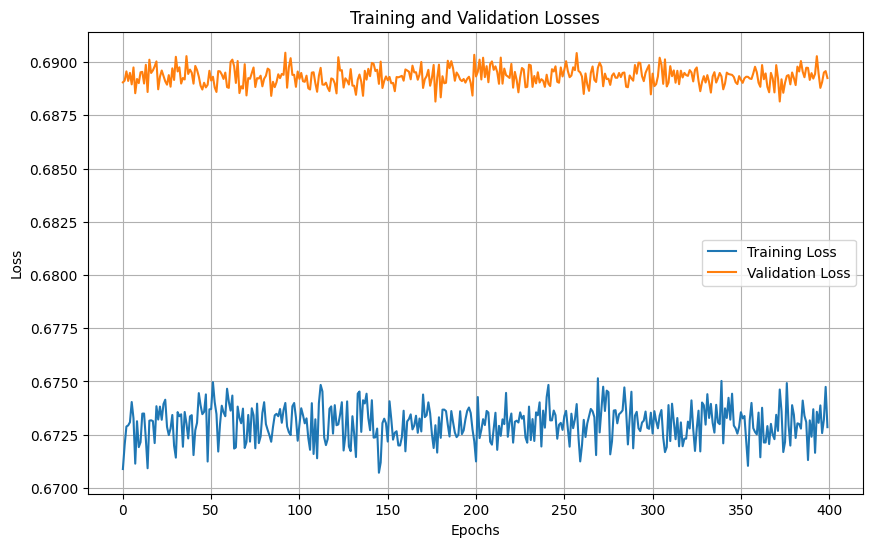

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
print(train_losses[0], train_losses[100])

0.6708894880378947 0.6729825577315163


## Testing

In [11]:
if (os.path.exists('model_weights.pth')):
  print("Loading Model")
  model.load_state_dict(torch.load('model_weights.pth', weights_only=True))

model.eval()
size = len(test_loader.dataset)
num_batches = len(test_loader)
test_loss, correct = 0, 0

# Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
# also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X.to(model.device))
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

correct /= size
print(f"Test Accuracy: {(100*correct):>0.1f}%")

Loading Model
Test Accuracy: 65.4%
